データ可視化を行うノートブック

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

In [25]:
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


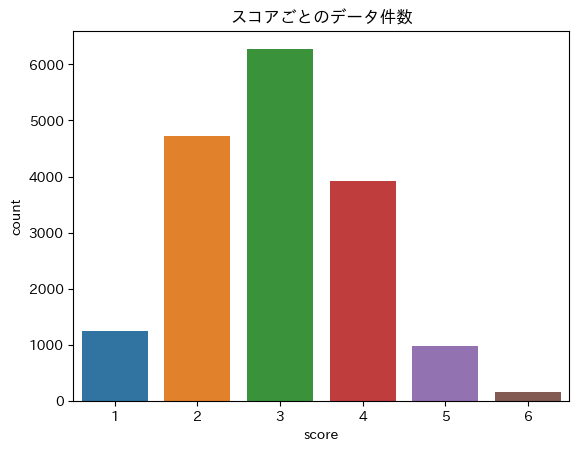

In [26]:
fig,ax = plt.subplots()
sns.countplot(x='score',data=df_train,ax=ax)
ax.set_title('スコアごとのデータ件数')
plt.show()

In [27]:
df_train['text_len'] = df_train.full_text.str.len()
df_train.head()

,essay_id,full_text,score,text_len
0,000d118,Many people have car where they live. The thin...,3,2677
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669
2,001ab80,People always wish they had the same technolog...,4,3077
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208


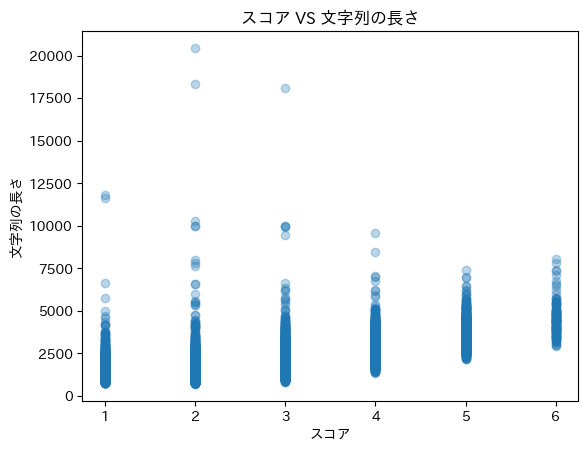

In [28]:
#文章が長いほどスコアが高いのではないか
fig,ax = plt.subplots()
ax.scatter(df_train.score,df_train.text_len,alpha=0.3)
ax.set_xlabel('スコア')
ax.set_ylabel('文字列の長さ')
ax.set_title('スコア VS 文字列の長さ')
plt.show()

・文字列と長さは無相関に見える

In [29]:
df_train['space_count'] = df_train.full_text.str.count(' ')
df_train['word_len_avg'] = (df_train.text_len - df_train.space_count) / (df_train.space_count + 1)
df_train.head()

,essay_id,full_text,score,text_len,space_count,word_len_avg
0,000d118,Many people have car where they live. The thin...,3,2677,496,4.388330
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,327,4.091463
2,001ab80,People always wish they had the same technolog...,4,3077,555,4.535971
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,446,5.044743
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,380,4.797900


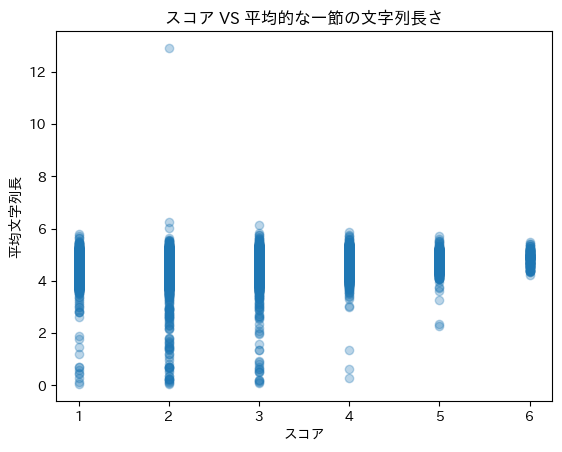

In [30]:
#一節が長めだとスコアが高いのではないか？
fig, ax = plt.subplots()
ax.scatter(df_train.score,df_train.word_len_avg,alpha=0.3)
ax.set_title('スコア VS 平均的な一節の文字列長さ')
ax.set_xlabel('スコア')
ax.set_ylabel('平均文字列長')
plt.show()

In [31]:
#「I」で始まる小論文は自分が足りでスコアが低いのではないか
df_train['I-cnt'] = df_train.full_text.str.startswith('I') + df_train.full_text.str.count('. I ')
df_train.head()

,essay_id,full_text,score,text_len,space_count,word_len_avg,I-cnt
0,000d118,Many people have car where they live. The thin...,3,2677,496,4.388330,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,327,4.091463,2
2,001ab80,People always wish they had the same technolog...,4,3077,555,4.535971,0
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,446,5.044743,0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,380,4.797900,2


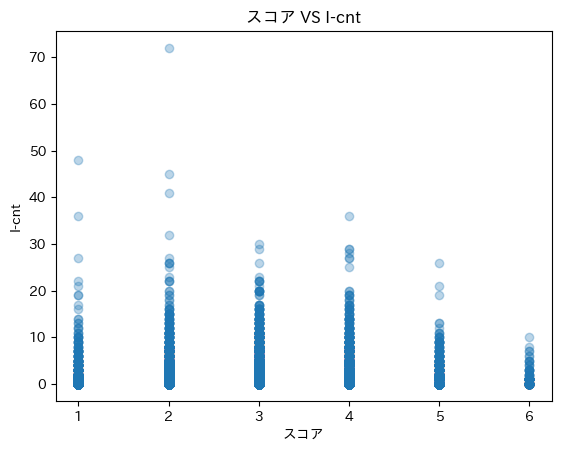

In [32]:
fig,ax = plt.subplots()
ax.scatter(df_train.score,df_train['I-cnt'],alpha=0.3)
ax.set_title('スコア VS I-cnt')
ax.set_xlabel('スコア')
ax.set_ylabel('I-cnt')
plt.show()

# 秋野編集

## ライブラリのインポート

In [33]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
import matplotlib.pyplot as plt
import japanize_matplotlib
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

## データ読み込み

In [34]:
# データフォルダの場所を設定
dataPath = "/data"

# データの読み出し
df = pd.read_csv(dataPath + "/train.csv")
scores = df["score"]
texts = df["full_text"]

## 全体の単語の使用回数を見てみる

In [35]:
# テキストをトークン化
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

In [36]:
# データ確認
# pd.DataFrame(tokenized_texts).head()

In [37]:
# 単語の使用回数を辞書として抽出する
word_dic = {}
for text in tokenized_texts:
    for word in text:
        if word in word_dic:
            word_dic[word] += 1
        else:
            word_dic[word] = 1

In [38]:
# 単語の使用回数をDataFrame型に変換する
# 回数の多い順でソートしておく
sorted_data = sorted(word_dic.items(), key=lambda item: item[1], reverse=True)
sorted_word_dic = dict(sorted_data)

# 辞書をDataFrameに変換
word_df = pd.DataFrame(list(sorted_word_dic.items()), columns=['word', 'count'])

In [39]:
# データ確認
word_df.head()

,word,count
0,the,368597
1,.,307224
2,",",213374
3,to,206999
4,a,157085


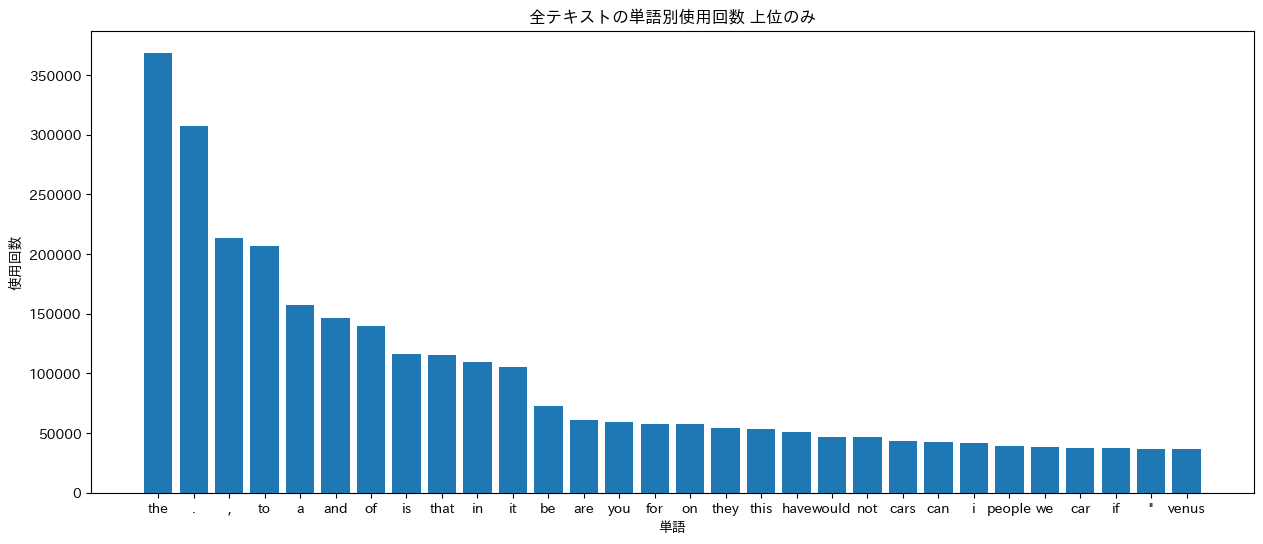

In [40]:
# 単語の使用回数をグラフ表示する
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(x=word_df['word'][:30], height=word_df['count'][:30])
ax.set_xlabel('単語')
ax.set_ylabel('使用回数')
ax.set_title('全テキストの単語別使用回数 上位のみ')
plt.show()

## スコアによって、使用単語の傾向が変わるか

使用単語回数と、スコアの相関関係を見る

In [41]:
# 必要なNLTKデータのダウンロード
nltk.download('punkt')
nltk.download('stopwords')

# stopword(意味のない単語)を設定
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 小文字に変換
    text = text.lower()
    # 単語にトークン化
    words = word_tokenize(text)
    # ストップワードの除去
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# データの読み出し
df = pd.read_csv(dataPath + "/train.csv")
df = df.head(8000).copy() # データ少な目で実験。全データにするとなぜかクラッシュする
scores = df["score"]
texts = df["full_text"]

df['processed_text'] = df['full_text'].apply(preprocess_text)

In [43]:
# CountVectorizerを使って単語の出現頻度をベクトル化
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])

# ベクトルをデータフレームに変換
words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# スコアを追加
words_df['score'] = df['score']

# データ確認
# words_df

In [44]:
# 相関計算のために単語列のみを抽出
words_only_df = words_df.drop(columns=['score'])

# 相関を計算し、結果をDataFrameに格納
correlations = {}
for word in words_only_df.columns:
    correlation, _ = pearsonr(words_only_df[word], words_df['score'])
    correlations[word] = correlation

# 相関(絶対値)の高い順にソート
sorted_correlations = sorted(correlations.items(), key=lambda item: item[1], reverse=True)

# 相関上位の単語とその相関値
top_words = pd.DataFrame(sorted_correlations, columns=['word', 'correlation'])

# データ確認
top_words.head()

,word,correlation
0,would,0.290901
1,many,0.265643
2,could,0.246512
3,even,0.243845
4,cars,0.241901


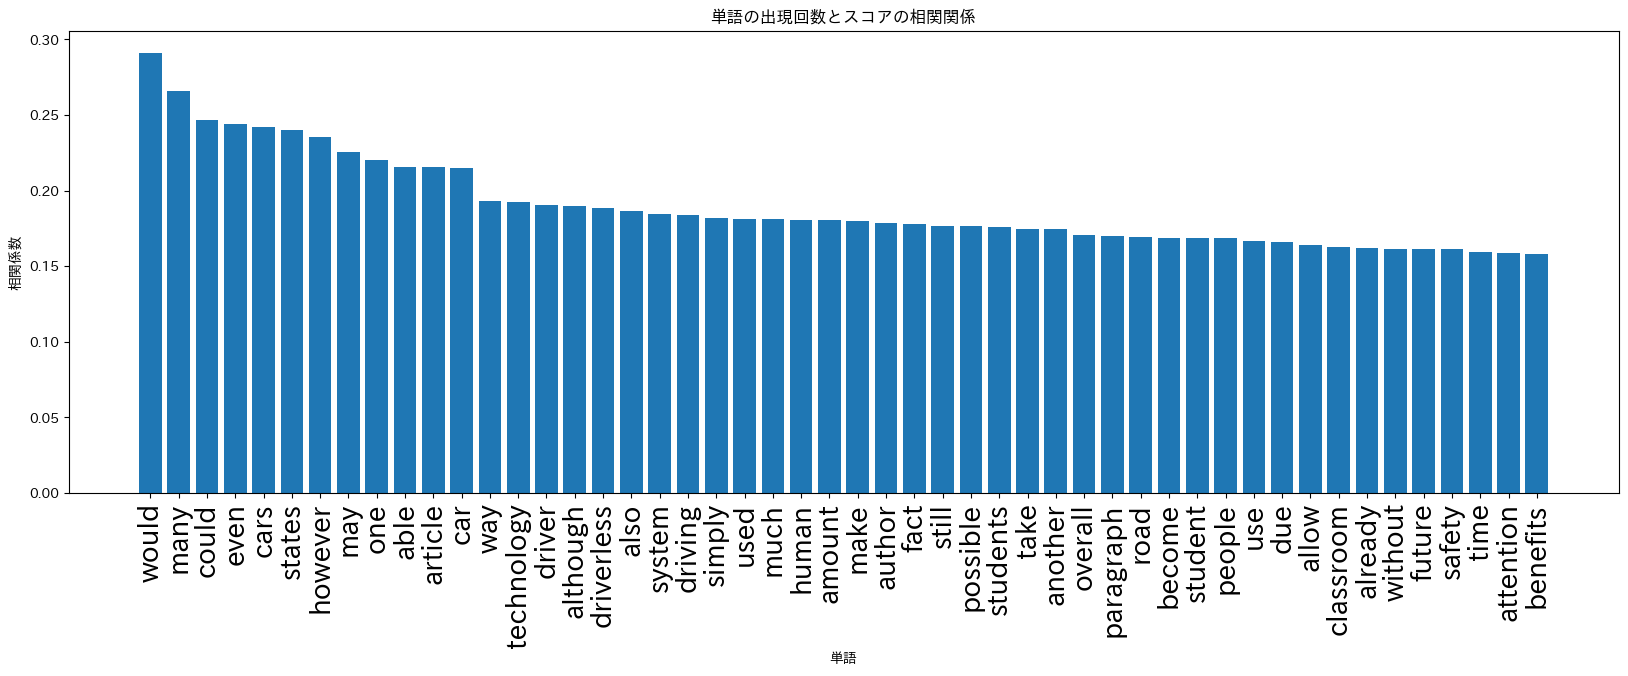

In [45]:
# 正の相関の強い単語をグラフ表示
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(x=top_words['word'][:50], height=top_words['correlation'][:50])
ax.set_xlabel('単語')
ax.set_ylabel('相関係数')
ax.set_title('単語の出現回数とスコアの相関関係')
plt.xticks(rotation=90, fontsize=20)
plt.show()

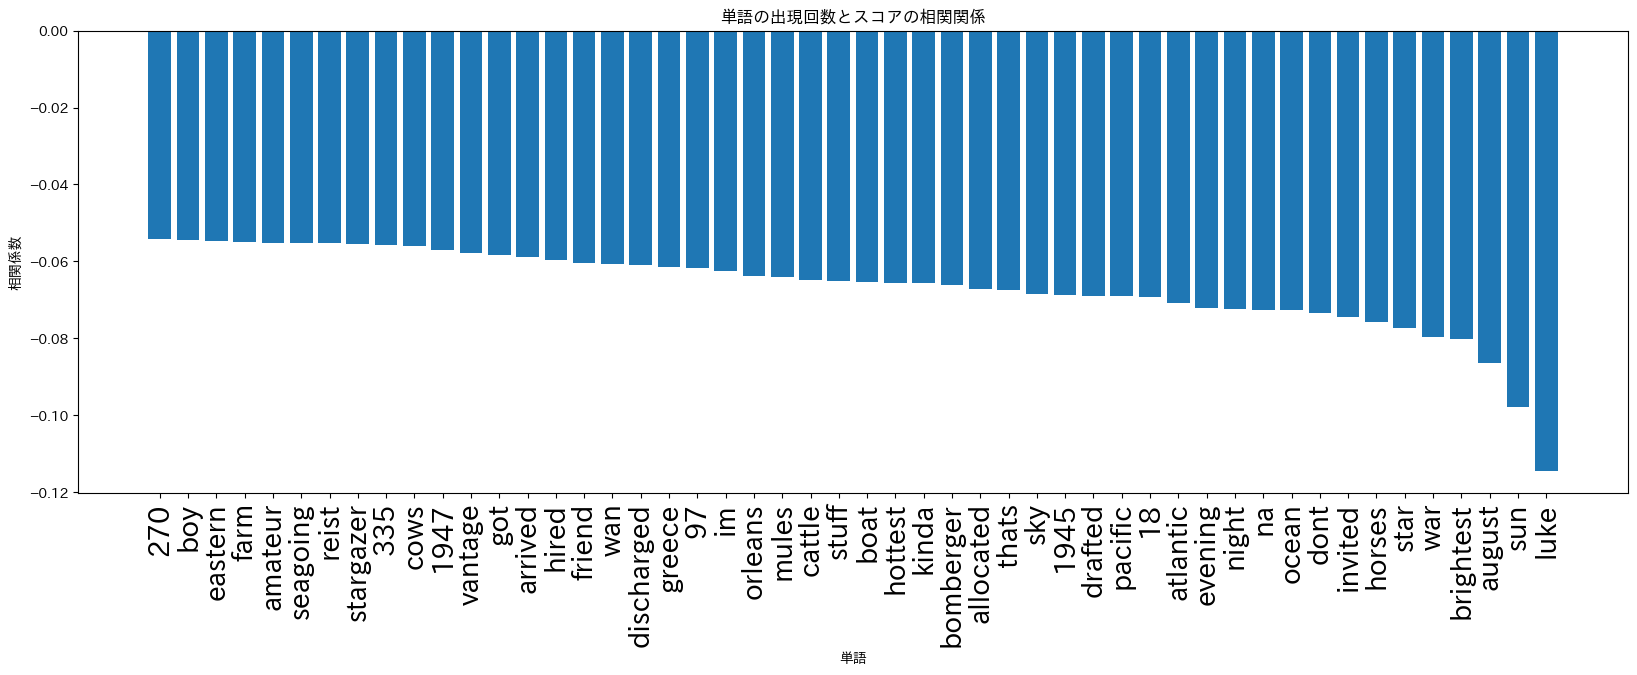

In [46]:
# 負の相関の強い単語をグラフ表示
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(x=top_words['word'][-50:], height=top_words['correlation'][-50:])
ax.set_xlabel('単語')
ax.set_ylabel('相関係数')
ax.set_title('単語の出現回数とスコアの相関関係')
plt.xticks(rotation=90, fontsize=20)
plt.show()

正の相関にしろ、負の相関にしろ、大した相関関係はなさそう  
正の相関の上位は少し相関があるが、あまりキーワード的な言葉には見えない